# Повышение качества звука на записи

In [4]:
import os
import subprocess
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from pydub import AudioSegment
from pydub.silence import split_on_silence
from scipy.io import wavfile

In [5]:
BASE_DIR = Path.cwd()  # Базовая директория эксперимента
AUDIO_DIR = BASE_DIR / "audio"  # Директория с аудио контентом
AUDIO_DIR.mkdir(exist_ok=True)
INPUT_FILE = AUDIO_DIR / "Голос 251024_120107.mp3"  # Файл для обработки
SAMPLE_RATE = 44_100  # Частота дискретизации

## Функция для конвертации аудио в WAV формат, используя FFmpeg

In [7]:
def convert_to_wav(
    input_filepath: str,
    output_filepath: str | None = None,
    wav_sample_rate: int = SAMPLE_RATE,
    wav_channels: int = 1,
) -> Path:
    """Конвертирует аудио файл в WAV формат, используя утилиту FFmpeg

    :param input_filepath: Путь до файла, который нужно конвертировать.
    :param output_filepath: Путь до ожидаемого WAV файла. Если путь не указан, то
    файл сохранится с аналогичным путём, что и входной файл.
    :param wav_sample_rate: Частота дискретизации WAV файла.
    :param wav_channels: Количество каналов у выходного файла.
    :return: Путь до сконвертированного файла.
    """
    input_filepath = Path(input_filepath)
    if not input_filepath.exists():
        raise FileNotFoundError(f"Input audio file not found: {input_filepath}")
    if output_filepath is None:
        output_filepath = input_filepath.with_suffix(".wav")
    else:
        output_filepath = Path(output_filepath)
    output_filepath.parent.mkdir(parents=True, exist_ok=True)
    ffmpeg_command = [
        "ffmpeg",
        "-i", str(input_filepath),  # Входной файл
        "-ac", f"{wav_channels}",  # Количество каналов
        "-ar", f"{wav_sample_rate}",  # Частота дискретизации
        "-acodec", "pcm_s16le",  # Кодек для WAV (16-bit PCM)
        "-f", "wav",  # Формат вывода
        "-hide_banner",  # Скрыть баннер ffmpeg
        "-loglevel", "error",  # Только ошибки в логах
        "-y",  # Перезаписывать выходной файл без подтверждения
        str(output_filepath)  # Выходной файл
    ]
    process = subprocess.Popen(  # noqa: S603
        ffmpeg_command,
        stdout=subprocess.PIPE,  # Перехватываем stdout
        stderr=subprocess.PIPE,  # Перехватываем stderr для ошибок
        text=True  # Для текстового вывода ошибок
    )
    _, stderr = process.communicate()
    if process.returncode != 0:
        error_message = stderr or "Unknown error"
        raise RuntimeError(f"Error while ffmpeg convert to 'wav', message: {error_message}")
    if not output_filepath.exists() or output_filepath.stat().st_size == 0:
        raise RuntimeError(
            "ffmpeg failed to convert to wav, output file is empty or not created"
        )
    return output_filepath

In [8]:
wav_file = convert_to_wav(INPUT_FILE)  # Конвертация файла

## Визуализация сырой аудио записи

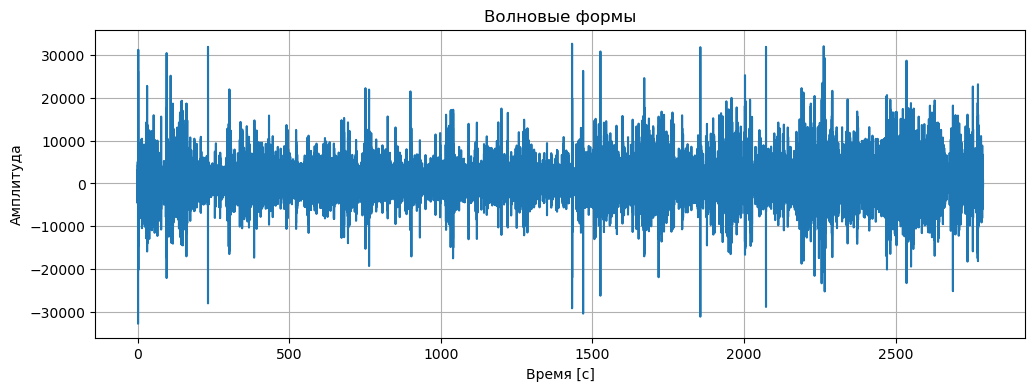

In [9]:
# Загрузка аудио-файла
sample_rate, audio_data = wavfile.read(wav_file)
# Создание оси времени
time = np.linspace(0., len(audio_data) / sample_rate, len(audio_data))
# Визуализация волновой формы
plt.figure(figsize=(12, 4))
plt.plot(time, audio_data)
plt.xlabel("Время [с]")
plt.ylabel("Амплитуда")
plt.title("Волновые формы")
plt.grid(True)
plt.show()

C:\ProgramData\miniconda3\Lib\site-packages\matplotlib\axes\_axes.py:8283: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


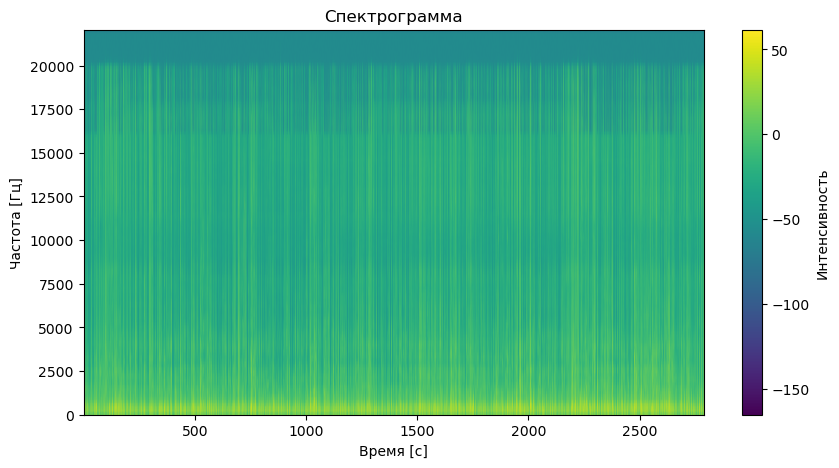

In [10]:
plt.figure(figsize=(10, 5))
plt.specgram(audio_data, Fs=sample_rate, cmap="viridis")
plt.xlabel("Время [c]")
plt.ylabel("Частота [Гц]")
plt.title("Спектрограмма")
plt.colorbar(label="Интенсивность")
plt.show()

## Разделение аудио на чанки по тихим паузам

In [12]:
def split_on_chunks_by_silence(
    input_filepath: str | Path,
    output_dir: str | Path,
    min_chunk_duration: int = 600_000
) -> list:
    input_filename = Path(input_filepath).stem
    audio = AudioSegment.from_file(input_filepath)
    chunks = split_on_silence(
        audio,
        min_silence_len=1000,  # Минимальная длина тишины для разделения (1 сек)
        silence_thresh=-40,    # Порог тишины в dB
        keep_silence=200       # Оставляем немного тишины (200 мс) для естественности
    )
    # Объединяем чанки до достижения минимальной длительности
    combined_chunks = []
    current_chunk = chunks[0]
    for chunk in chunks[1:]:
        if len(current_chunk) + len(chunk) <= min_chunk_duration:
            current_chunk += chunk
        else:
            combined_chunks.append(current_chunk)
            current_chunk = chunk
    if current_chunk:
        combined_chunks.append(current_chunk)
    # Сохраняем чанки
    os.makedirs(output_dir, exist_ok=True)
    for i, chunk in enumerate(combined_chunks):
        output_file = os.path.join(output_dir, f"{input_filename}_chunk_{i + 1:03d}.wav")
        chunk.export(output_file, format="wav")
    return combined_chunks

In [13]:
CHUNKS_DIR = BASE_DIR / "chunks"

chunks = split_on_chunks_by_silence(
    input_filepath=wav_file, output_dir=CHUNKS_DIR,
)

## Обработка аудио
 - Подавление фонового шума
 - Компрессия, выравнивание громкости
 - Усиление низких частот
 - Усиление (увеличение общей громкости на 2dB после обработки)

In [20]:
import soundfile as sf
from pedalboard import Compressor, Gain, LowShelfFilter, NoiseGate, Pedalboard

PROCESSED_CHUNKS_DIR = BASE_DIR / "processed_chunks"

PROCESSED_CHUNKS_DIR.mkdir(exist_ok=True)

board = Pedalboard([
    NoiseGate(threshold_db=-30, ratio=1.5, release_ms=250),
    Compressor(threshold_db=-16, ratio=4, attack_ms=5, release_ms=100),
    LowShelfFilter(cutoff_frequency_hz=400, gain_db=8, q=1),
    Gain(gain_db=2)
])

for filepath in CHUNKS_DIR.iterdir():
    print(f"Strat processing with pedalboard {filepath.name}")  # noqa: T201
    audio, sample_rate = sf.read(filepath)
    effected = board(audio, sample_rate)
    effected_filepath = PROCESSED_CHUNKS_DIR / f"processed_{filepath.name}"
    sf.write(effected_filepath, effected, sample_rate)
    print(f"Finish processing with pedalboard {filepath.name}")  # noqa: T201

Strat processing with pedalboard Голос 251024_120107_chunk_001.wav
Finish processing with pedalboard Голос 251024_120107_chunk_001.wav
Strat processing with pedalboard Голос 251024_120107_chunk_002.wav
Finish processing with pedalboard Голос 251024_120107_chunk_002.wav
Strat processing with pedalboard Голос 251024_120107_chunk_003.wav
Finish processing with pedalboard Голос 251024_120107_chunk_003.wav
Strat processing with pedalboard Голос 251024_120107_chunk_004.wav
Finish processing with pedalboard Голос 251024_120107_chunk_004.wav


In [21]:
from pydub.effects import normalize

OUTPUT_FILE = AUDIO_DIR / f"processed_{INPUT_FILE.stem}.wav"

combined = AudioSegment.empty()

for filepath in PROCESSED_CHUNKS_DIR.iterdir():
    audio = AudioSegment.from_file(filepath)
    audio = normalize(audio)  # Нормализация громкости
    combined += audio
    
combined.export(OUTPUT_FILE, format="wav")

<_io.BufferedRandom name='C:\\Users\\andre\\DIOProjects\\dio-audio-summarization\\notebooks\\enhancement_sound_quality\\audio\\processed_Голос 251024_120107.wav'>

In [25]:
# Отчистка от промежуточных данных

import shutil

shutil.rmtree(CHUNKS_DIR)
shutil.rmtree(PROCESSED_CHUNKS_DIR)

## Аудио после обработки

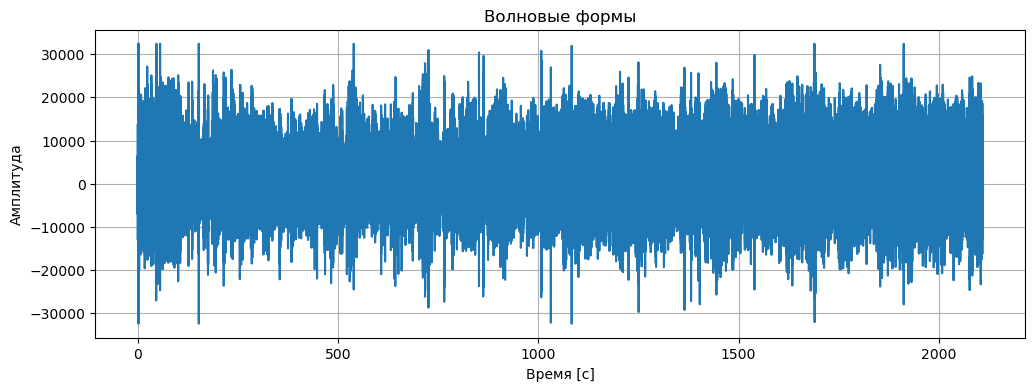

In [22]:
sample_rate, audio_data = wavfile.read(OUTPUT_FILE)
# Создание оси времени
time = np.linspace(0., len(audio_data) / sample_rate, len(audio_data))
# Визуализация волновой формы
plt.figure(figsize=(12, 4))
plt.plot(time, audio_data)
plt.xlabel("Время [с]")
plt.ylabel("Амплитуда")
plt.title("Волновые формы")
plt.grid(True)
plt.show()

C:\ProgramData\miniconda3\Lib\site-packages\matplotlib\axes\_axes.py:8283: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


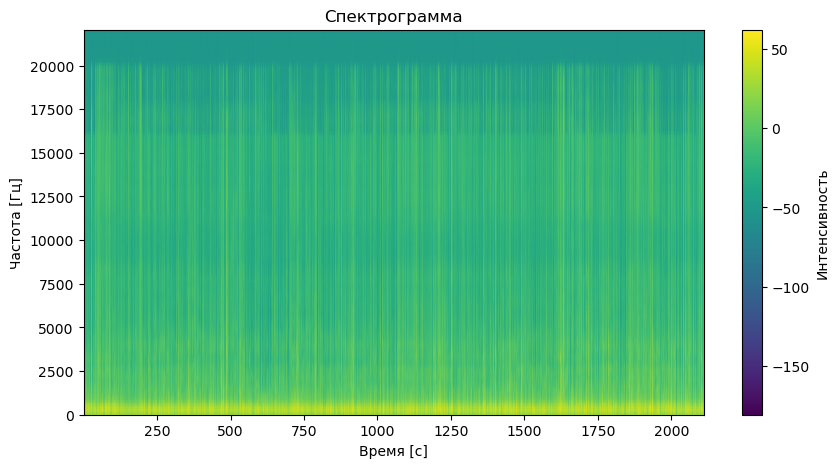

In [23]:
plt.figure(figsize=(10, 5))
plt.specgram(audio_data, Fs=sample_rate, cmap="viridis")
plt.xlabel("Время [c]")
plt.ylabel("Частота [Гц]")
plt.title("Спектрограмма")
plt.colorbar(label="Интенсивность")
plt.show()